In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
LowerGameBound = 100

In [2]:
##Aggregate the Batter data.
def cleanGL(x):
    try:
        out = float(x)
    except:
        try:
            out = float(x.strip('%'))
        except:
            out = 0
    return out

In [3]:
def MakeStdRowBatter(GameLog):
    PA = GameLog.values[0,7]
    GameLogStd=GameLog.drop(['DKfp'], axis=1)
    CleanRow = [x/PA for x in map(cleanGL,GameLogStd.values[0,8:24])]+[x for x in map(cleanGL,GameLogStd.values[0,24:])]
    return CleanRow

In [4]:
def MakeHandRowBatter(SplitLog):
    PAL = SplitLog.values[4,4]
    PAR = SplitLog.values[5,4]
    CleanRowL = [x/PAL for x in map(cleanGL,SplitLog.values[4,8:24])]+[x for x in map(cleanGL,SplitLog.values[4,24:])]
    CleanRowR = [x/PAR for x in map(cleanGL,SplitLog.values[5,8:24])]+[x for x in map(cleanGL,SplitLog.values[5,24:])]
    return CleanRowL+CleanRowR

In [5]:
CurrentBattingRoster = pd.read_csv('../Data/DataBaseCrawler/MLBBatterRoster2018.csv', index_col=0)
CurrentBattingRoster = CurrentBattingRoster[['Name','Team','ID']]
CurrentBattingRoster.drop_duplicates()
nc,dc = CurrentBattingRoster.shape

In [6]:
AggregatedBatterDataFrame=pd.read_csv('../Data/DataBaseCrawler/GameLogs/InactiveBatterList.csv',index_col=0)
AggregatedBatterDataFrame.drop_duplicates(subset=['ID'], inplace=True)
AggregatedBatterDataFrame = AggregatedBatterDataFrame[~AggregatedBatterDataFrame['ID'].isin(CurrentBattingRoster['ID'])]

In [7]:
CurrentBattingRoster.values

array([['J.D. Martinez', 'Red Sox', 6184],
       ['Andrew Benintendi', 'Red Sox', 17901],
       ['Brock Holt', 'Red Sox', 9345],
       ...,
       ['Chris Davis', 'Orioles', 9272],
       ['Colby Rasmus', 'Orioles', 9893],
       ['Corban Joseph', 'Orioles', 5503]], dtype=object)

In [8]:
#Get the current players
NamesPredictee = []
NamesPredictor = []
IDPredictee = []
IDPredictor = []
DataPredictor = []
DataPredictee = []
ActivePredictor = []
ActivePredictee = []
for row in CurrentBattingRoster.values:
    #Grab the row
    ID = row[2]

    #Grab the GameLog
    GameLog = pd.read_csv('../Data/DataBaseCrawler/GameLogs/Batters/'+str(ID)+'GL.csv',index_col=0)

    #Grab the splitLogs
    SplitLogHand = pd.read_csv('../Data/DataBaseCrawler/GameLogs/Batters/'+str(ID)+'HandSL.csv', index_col=0)

    #Get the fantasy points values.
    Var = np.var(GameLog['DKfp'][1:])
    mean = np.mean(GameLog['DKfp'][1:])

    #Build the row
    if GameLog.values[0,5] > LowerGameBound:
        NamesPredictor.append(row[0])
        IDPredictor.append(ID)
        ActivePredictor.append('Y')
        RowSTD = MakeStdRowBatter(GameLog) +[mean,Var]
        RowSLHand = MakeHandRowBatter(SplitLogHand)
        DataPredictor.append(RowSTD+RowSLHand)
    else:
        NamesPredictee.append(row[0])
        IDPredictee.append(ID)
        ActivePredictee.append('Y')
        RowSTD = MakeStdRowBatter(GameLog) +[mean,Var]
        RowSLHand = MakeHandRowBatter(SplitLogHand)
        DataPredictee.append(RowSTD+RowSLHand)
    
PlayersFeatures = np.array(DataPredictor)
PlayersNames = NamesPredictor
IDList = IDPredictor
Active = ActivePredictor

In [10]:
BadIDs = [123,79,1391,981,48,51,766,482,389,713,5834,9312,122,1233,1109,1719,9414,472,1616,1436,860,364,275,194,609,335,246,1406,336,155,478,1836,381,784,1588,595,691,1427,366,1019,1376,1309,1493,939,2024,1167,1610,1396,1498,1302,540,1748,7707,463,1499,1403,661,1762,1762,2338,1486,1438,1927,1078,1216,286,438,8607,621,942,1999,268,1533,12,834,163,660,2962,1834,11863,1954,5198,1805,4464,5128,1380,4409,4390,8760,1629,900,1382,763,2784,722,298,1024,1262,173,26,3972]

In [11]:
#Get the old players
for row in AggregatedBatterDataFrame.values:
    #row = AggregatedBatterDataFrame
    #Grab the row
    ID = row[1]

    #Grab the GameLog
    GameLog = pd.read_csv('../Data/DataBaseCrawler/GameLogs/InactiveBatters/'+str(ID)+'GL.csv', index_col=0)

    #Grab the splitLogs
    SplitLogHand = pd.read_csv('../Data/DataBaseCrawler/GameLogs/InactiveBatters/'+str(ID)+'HandSL.csv',index_col=0)

    #Get the fantasy points values.
    mean = np.mean(GameLog['DKfp'][1:])
    Var = np.var(GameLog['DKfp'][1:])

    #Build the row
    if GameLog.values[0,5] > LowerGameBound and ID not in BadIDs:
        IDList.append(ID)
        PlayersNames.append(row[0])
        Active.append('N')
        RowSTD = MakeStdRowBatter(GameLog)+[mean, Var]
        RowSLHand = MakeHandRowBatter(SplitLogHand)
        PlayersFeatures=np.concatenate((PlayersFeatures,np.array([RowSTD+RowSLHand])), axis=0)

In [12]:
#Scale the data
scaler = StandardScaler(copy=False)
scaler.fit(PlayersFeatures)

StandardScaler(copy=False, with_mean=True, with_std=True)

In [13]:
ScaledPlayerFeatures = scaler.transform(PlayersFeatures)
ScaledDataPredictee = scaler.transform(DataPredictee)
ScaledPlayerFeatures.shape

(1395, 85)

In [14]:
#Cluster the players - Try a number of clusters and look at error.
Errors = []
NumClusters = range(0,50)
kmeans = [KMeans(n_clusters=i+1) for i in NumClusters]
for model in kmeans:
    model.fit(ScaledPlayerFeatures)
    Errors.append(model.score(ScaledPlayerFeatures))
    print("K: %d Error: %f " % (model.n_clusters, model.score(ScaledPlayerFeatures)));print(np.bincount(model.labels_))

K: 1 Error: -118575.000000 
[1395]
K: 2 Error: -95868.998010 
[724 671]
K: 3 Error: -88584.649232 
[640 217 538]
K: 4 Error: -81820.968684 
[266 382 194 553]
K: 5 Error: -78045.959546 
[288 176 227 349 355]
K: 6 Error: -75706.790702 
[280 158 199 153 294 311]
K: 7 Error: -73450.984104 
[277 243 142 185 177 129 242]
K: 8 Error: -71675.338602 
[136 228 219 208 120 176 178 130]
K: 9 Error: -70241.294645 
[157 129 182  73 228 174 198 145 109]
K: 10 Error: -68821.768016 
[171 162  54 224 129  79  93 180 206  97]
K: 11 Error: -67691.904173 
[ 56 165  75 167  79 101 120 113 149 182 188]
K: 12 Error: -66457.586312 
[155  98 107  82 151  72 179 134  91 175  42 109]
K: 13 Error: -65496.572015 
[100  47  92 144 138  98 190 102 160  53 113 103  55]
K: 14 Error: -64535.764138 
[ 80 154  89 108  39  96 137 110 105 156 135  83  54  49]
K: 15 Error: -63672.002616 
[153 117 101  90  63 108 136  54  57  59  99  50 117 114  77]
K: 16 Error: -63287.600096 
[ 62 110 128  67  57  44 135 105  53 132  96  61 

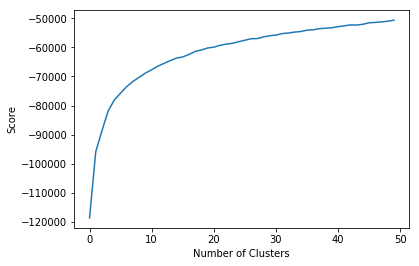

In [15]:
plt.plot(NumClusters,Errors)
plt.ylabel('Score')
plt.xlabel("Number of Clusters")
plt.show()

In [16]:
#Histogram for Diffetant Means

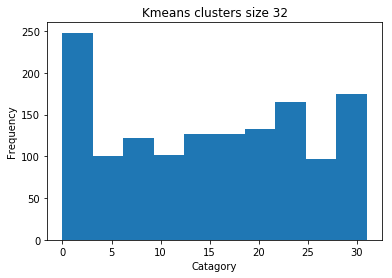

In [17]:
ClusterNum = 32
plt.hist(kmeans[ClusterNum-1].labels_)
plt.title("Kmeans clusters size "+str(ClusterNum))
plt.xlabel("Catagory")
plt.ylabel("Frequency")
plt.show()

In [18]:
np.bincount(kmeans[ClusterNum-1].labels_)

array([ 18,  65,  61, 104,  49,  26,  25,  24,  68,  30,  56,  13,  32,
        70,  18,  39,  20,  41,  66,  49,  34,  50,  65,  62,  38,  45,
        31,  21,  41,  60,  37,  37])

In [19]:
#Use this to look at clusters. 173,26,3972]
PredictorDF = pd.DataFrame()
PredictorDF['Name'] = PlayersNames
PredictorDF['ID'] = IDList
PredictorDF['Labels'] = kmeans[ClusterNum-1].labels_
PredictorDF['Active'] = Active
BadLabelDF = PredictorDF[PredictorDF['Labels']==5]
BadLabelDF

,Name,ID,Labels,Active
128,Max Stassi,10059,5,Y
176,Matt Reynolds,13788,5,Y
241,Brandon Snyder,9856,5,Y
444,Andrew Susac,13132,5,Y
462,Benny Agbayani,416,5,N
463,Chris Aguila,2143,5,N
498,Brian Banks,1589,5,N
575,Joey Butler,7799,5,N
678,Joe Dillon,2384,5,N
708,Alex Escobar,383,5,N


In [20]:
#Predict other Batters.
PredicteeLabels = kmeans[ClusterNum-1].predict(ScaledDataPredictee)

In [21]:
#Aggregate Batter results
TotalLabels = np.concatenate((kmeans[ClusterNum-1].labels_,PredicteeLabels))
TotalPlayersNames = PlayersNames + NamesPredictee
IDListTotal = IDList + IDPredictee
TotalActive = Active + ActivePredictee

In [22]:
#Create the total DF
TotalDF = pd.DataFrame()
TotalDF['Name'] = TotalPlayersNames
TotalDF['ID'] = IDListTotal
TotalDF['Labels'] = TotalLabels
TotalDF['Active'] = TotalActive
TotalDF.values

array([['J.D. Martinez', 6184, 30, 'Y'],
       ['Andrew Benintendi', 17901, 3, 'Y'],
       ['Brock Holt', 9345, 23, 'Y'],
       ...,
       ['Steve Wilkerson', 16041, 5, 'Y'],
       ['Chance Sisco', 15694, 14, 'Y'],
       ['Corban Joseph', 5503, 5, 'Y']], dtype=object)

In [23]:
#Remove clusters with no active players.
ActiveClusters = []
for label in range(ClusterNum):
    #There is probably a better way to do this, but whatever.
    Players = TotalDF.values[[x[2]==label for x in TotalDF.values ]]
    if 'Y' in Players[:,3]:
        ActiveClusters.append(label)
print([item for item in range(ClusterNum) if item not in ActiveClusters])

[]


In [24]:
#Remove players with inactive clusters
TotalDF = TotalDF[TotalDF['Labels'].isin(ActiveClusters)]

In [25]:
#Look at final bin count. 15 20
np.bincount(TotalDF['Labels'])

array([ 27,  67,  64, 104,  49,  84,  25,  27,  68,  30,  56,  13,  34,
        70,  59,  44,  20,  43,  67,  52,  57,  55,  66,  62,  38,  45,
        31,  22,  41,  60,  37,  37])

In [26]:
#Num total players
sum(np.bincount(TotalDF['Labels']))

1554

In [27]:
#Build predictor Dataframe
PredictorDF = pd.DataFrame()
PredictorLabels = kmeans[ClusterNum-1].labels_
PredictorPlayersNames = PlayersNames
IDListPredictor = IDList
PredictorActive = Active

In [28]:
PredictorDF['Name'] = PlayersNames
PredictorDF['ID'] = IDList
PredictorDF['Labels'] = PredictorLabels
PredictorDF['Active'] = Active
PredictorDF.values

array([['J.D. Martinez', 6184, 30, 'Y'],
       ['Andrew Benintendi', 17901, 3, 'Y'],
       ['Brock Holt', 9345, 23, 'Y'],
       ...,
       ['Kevin Young', 1018, 1, 'N'],
       ['Gregg Zaun', 580, 13, 'N'],
       ['Todd Zeile', 457, 13, 'N']], dtype=object)

In [29]:
PredictorDF = PredictorDF[PredictorDF['Labels'].isin(ActiveClusters)]
np.bincount(PredictorDF['Labels'])

array([ 18,  65,  61, 104,  49,  26,  25,  24,  68,  30,  56,  13,  32,
        70,  18,  39,  20,  41,  66,  49,  34,  50,  65,  62,  38,  45,
        31,  21,  41,  60,  37,  37])

In [30]:
#Save CSV files.
TotalDF.to_csv('./BatterClusters/TotalBattingClusters.csv')
PredictorDF.to_csv('./BatterClusters/PredBattingClusters.csv')